N Data: 2 | N Correct: 2 | Accuracy: 100.00%

Task d364b489 | Test 1: {'pad_size': 1, 'max_width': 3, 'max_height': 3, 'dims_reduced': [9], 'dims_decoded': [1], 
'pad_class_initial': 0, 'pad_num_layers': 1, 'pad_n_head': None, 'pad_dim_feedforward': 1, 'L_num_layers': 6, 
'L_n_head': None, 'L_dim_feedforward': 1, 'C_num_layers': 1, 'C_n_head': None, 'C_dim_feedforward': 1, 'dropout': 
0.1, 'num_classes': 10}

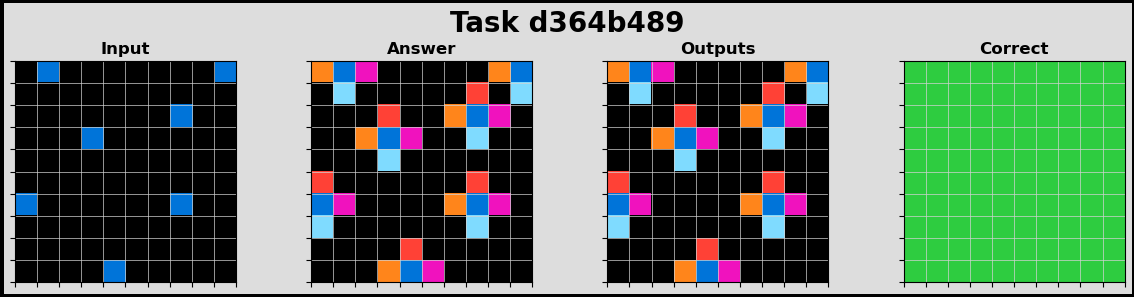

Task d364b489 | Test 1: {'pad_size': 1, 'max_width': 3, 'max_height': 3, 'dims_reduced': [9], 'dims_decoded': [1], 
'pad_class_initial': 0, 'pad_num_layers': 1, 'pad_n_head': None, 'pad_dim_feedforward': 1, 'L_num_layers': 6, 
'L_n_head': None, 'L_dim_feedforward': 1, 'C_num_layers': 1, 'C_n_head': None, 'C_dim_feedforward': 1, 'dropout': 
0.1, 'num_classes': 10}

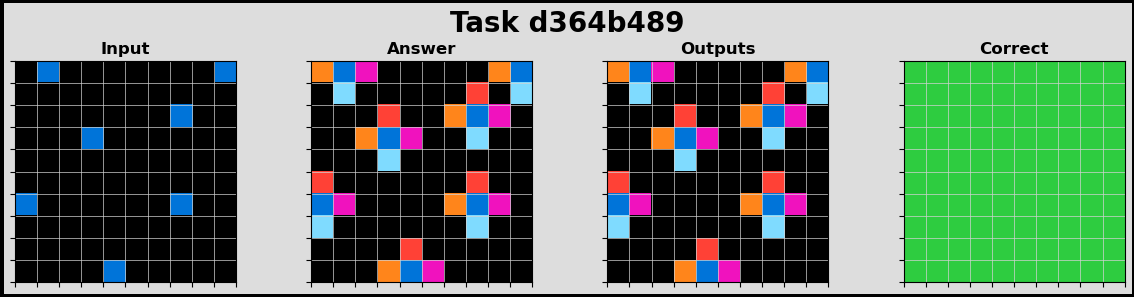

Task 95990924 | Test 1: {'pad_size': 1, 'max_width': 3, 'max_height': 3, 'dims_reduced': [9], 'dims_decoded': [1], 
'pad_class_initial': 0, 'pad_num_layers': 1, 'pad_n_head': None, 'pad_dim_feedforward': 1, 'L_num_layers': 6, 
'L_n_head': None, 'L_dim_feedforward': 1, 'C_num_layers': 1, 'C_n_head': None, 'C_dim_feedforward': 1, 'dropout': 
0.1, 'num_classes': 10}

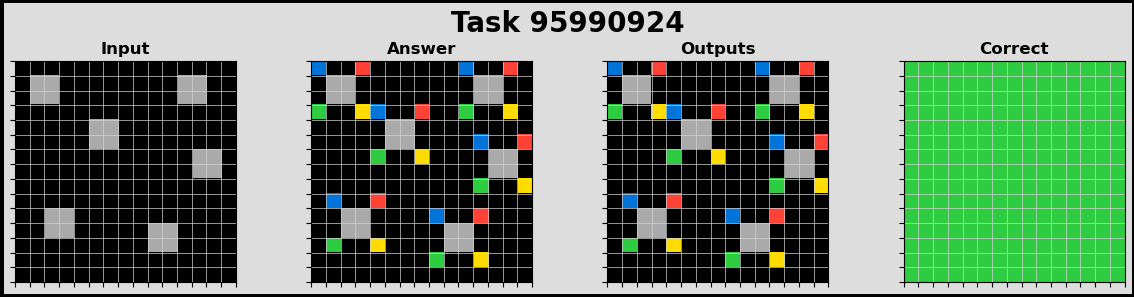

Task 95990924 | Test 1: {'pad_size': 1, 'max_width': 3, 'max_height': 3, 'dims_reduced': [9], 'dims_decoded': [1], 
'pad_class_initial': 0, 'pad_num_layers': 1, 'pad_n_head': None, 'pad_dim_feedforward': 1, 'L_num_layers': 6, 
'L_n_head': None, 'L_dim_feedforward': 1, 'C_num_layers': 1, 'C_n_head': None, 'C_dim_feedforward': 1, 'dropout': 
0.1, 'num_classes': 10}

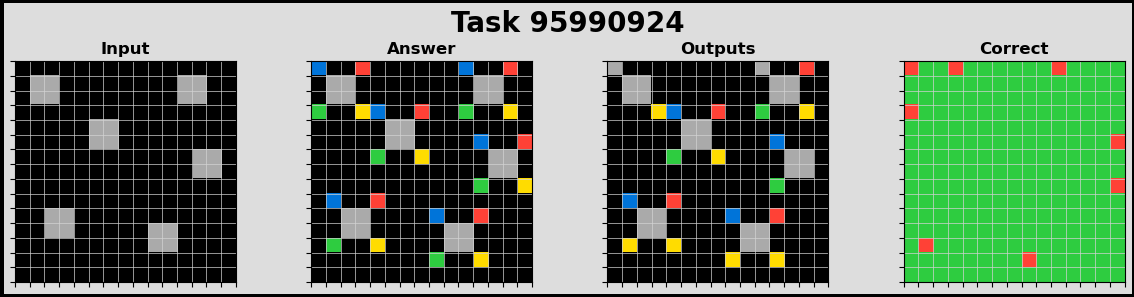

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from arc.utils.visualize import plot_xyt_from_json

file_path = '../../output/test_results.json'
plot_xyt_from_json(file_path, plot_only_correct=True)